In [1]:
#Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
import seaborn as sns
import os
import matplotlib.dates as mdates

from datetime import datetime

from sklearn.preprocessing import  MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, cross_validate, learning_curve, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.metrics import matthews_corrcoef, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier, cv, plot_importance

from scipy.stats import uniform, randint
import time
import joblib
import os


import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
login_df = pd.read_json('logins.json')
login_df['login_count'] = 1

In [3]:
login_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   login_time   93142 non-null  datetime64[ns]
 1   login_count  93142 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.4 MB


### There are 0 null values in our data

# Part 1 ‐ Exploratory data analysisThe attached logins.json file contains (simulated) timestamps of user logins in a particulargeographic location. Aggregate these login counts based on 15minutetime intervals, andvisualize and describe the resulting time series of login counts in ways that best characterize theunderlying patterns of the demand. Please report/illustrate important features of the demand,such as daily cycles. If there are data quality issues, please report them.

In [4]:
login_df = login_df.set_index(pd.to_datetime(login_df['login_time'], unit='s'))[['login_count']]
login_df.head()

,login_count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [5]:
logins_15_df = login_df.resample('15Min').sum()
logins_15_df.head()

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [6]:
logins_15_df.describe()

,login_count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


# The mean number of logins per 15 minute interval is 9.5 logins with the max being 73 logins

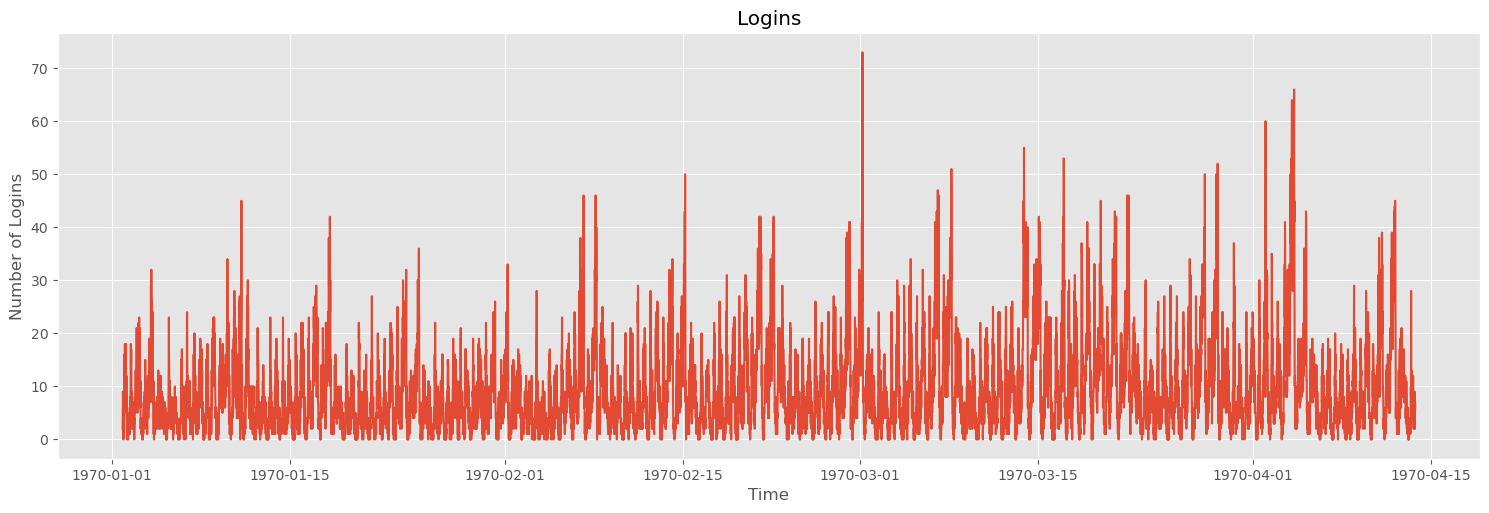

In [7]:
# Logins Lineplot
login_scatter = fig, ax = plt.subplots(figsize = (15,5))
login_scatter = sns.lineplot(x=logins_15_df.index, y=logins_15_df.login_count, ax=ax)
login_scatter = plt.xlabel('Time')
login_scatter = plt.ylabel('Number of Logins')
login_scatter = plt.tight_layout()
login_scatter = plt.title('Logins')

# Our logins lineplot shows that there is a cyclical nature to our data, but we'll need to zoom in further to draw additional insights.

In [8]:
# aggregate by day
logins_daily = logins_15_df.resample('D').sum()
logins_weekday = logins_15_df.resample('B').sum()
fridays = logins_15_df.resample('W-FRI').sum()
saturdays = logins_15_df.resample('W-SAT').sum()
sundays = logins_15_df.resample('W-SUN').sum()

In [9]:
# set indices to datetime
logins_daily.index = pd.to_datetime(logins_daily.index)
logins_weekday.index = pd.to_datetime(logins_weekday.index)
fridays.index = pd.to_datetime(fridays.index)
saturdays.index = pd.to_datetime(saturdays.index)
sundays.index = pd.to_datetime(sundays.index)

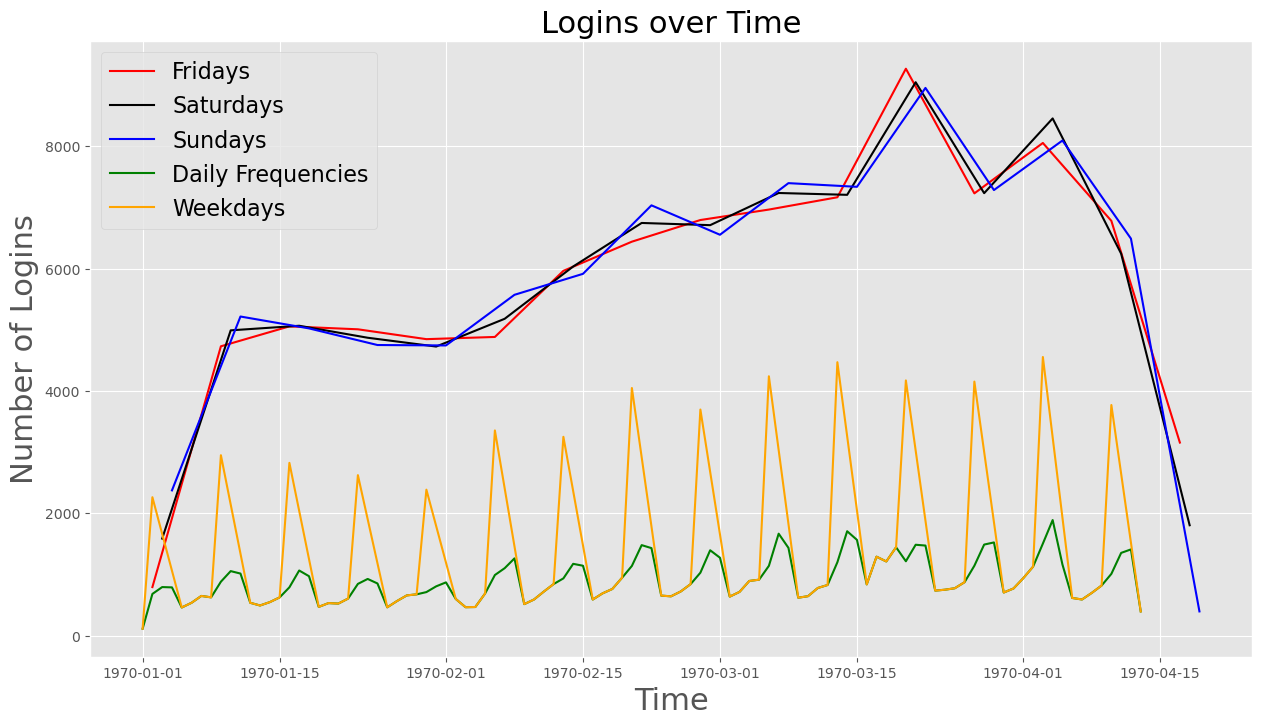

In [10]:
# Plot daily logins over time
line_daily = fig, ax = plt.subplots(figsize=(15, 8))

line_daily = sns.lineplot(x=fridays.index, y=fridays.login_count, label='Fridays', color='red', ax=ax)
line_daily = sns.lineplot(x=saturdays.index, y=saturdays.login_count, label='Saturdays', color='black', ax=ax)
line_daily = sns.lineplot(x=sundays.index, y=sundays.login_count, label='Sundays', color='blue', ax=ax)
line_daily = sns.lineplot(x=logins_daily.index, y=logins_daily.login_count, label='Daily Frequencies', color='green', ax=ax)
line_daily = sns.lineplot(x=logins_weekday.index, y=logins_weekday.login_count, label='Weekdays', color='orange', ax=ax)

line_daily = ax.set_xlabel('Time', fontsize=22)
line_daily = ax.set_ylabel('Number of Logins', fontsize=22)
line_daily = ax.set_title('Logins over Time', fontsize=22)
line_daily = ax.legend(loc='upper left', fontsize=16)

# Fridays, Saturdays, & Sundays clearly show more login activity compared to weekdays. The weekdays plot shows that there is an additional cyclical layer to explore so we'll zoom in to hourly to flesh out the trend.

In [11]:
# resample hourly
logins_daily = login_df.resample('H').sum()
day_of_week = list(logins_daily.index.dayofweek)
logins_daily['day_of_week'] = day_of_week
logins_daily['hour'] = [time.hour for time in logins_daily.index]
logins_daily.head()

,login_count,day_of_week,hour
login_time,,,
1970-01-01 20:00:00,24,3,20
1970-01-01 21:00:00,9,3,21
1970-01-01 22:00:00,21,3,22
1970-01-01 23:00:00,58,3,23
1970-01-02 00:00:00,53,4,0


In [12]:
# Pivot table for hourly logins by day
mean_logins_by_hour = pd.pivot_table(
    logins_daily, 
    values='login_count', 
    index='hour', 
    columns='day_of_week', 
    aggfunc='mean'  # Use the string 'mean' instead of np.mean
).rename(columns={0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

mean_logins_by_hour = mean_logins_by_hour.stack(level=['day_of_week'])
mean_logins_by_hour.name = 'mean_logins'
mean_logins_by_hour = mean_logins_by_hour.reset_index()
mean_logins_by_hour.head()

,hour,day_of_week,mean_logins
0,0,Monday,35.400000
1,0,Tuesday,43.357143
2,0,Wednesday,49.071429
3,0,Thursday,58.285714
4,0,Friday,65.000000


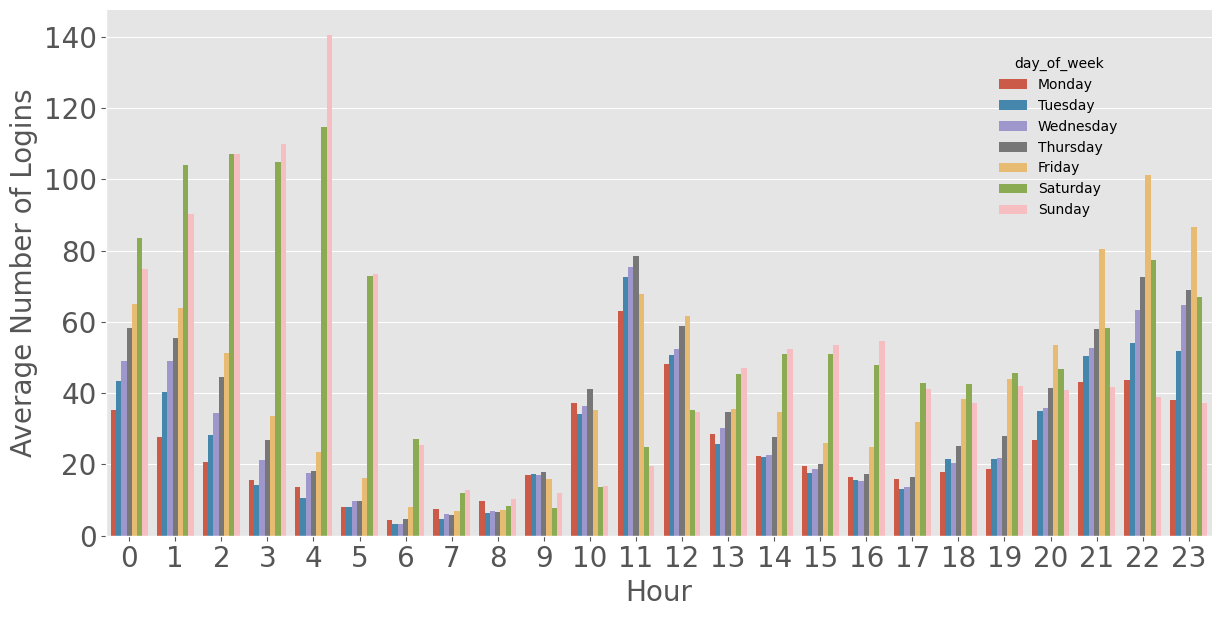

In [13]:
# Plot average hourly use
hour_plot = sns.catplot(
    x='hour', 
    y='mean_logins',  # Update this to match the column name after pivoting
    data=mean_logins_by_hour, 
    kind='bar', 
    hue='day_of_week', 
    height=6, 
    aspect=12/6, 
    legend=True
)

hour_plot.set_axis_labels('Hour', 'Average Number of Logins', fontsize=20)
hour_plot.set_titles('Mean Logins per Hour', fontsize=26)
hour_plot.set_xticklabels(hour_plot.ax.get_xticklabels(), fontsize=20)
hour_plot.ax.tick_params(axis='y', labelsize=20)
hour_plot.legend.set_bbox_to_anchor((.75, .75, 0.1, 0.1))

# Two trends stand out here.
1) On Saturdays and Sundays, the highest volume of logins occure between 1AM-5AM.
2) On Weekdays, there are two periods in the day with the highest volume; 10AM-1PM and 8PM-12AM

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
# Part 2 ‐ Experiment and metrics design#### The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.#### However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.1) What would you choose as the key measure of success of this experiment inencouraging driver partners to serve both cities, and why would you choose this metric?2) Describe a practical experiment you would design to compare the effectiveness of theproposed change in relation to the key measure of success. Please provide details on:a) how you will implement the experimentb) what statistical test(s) you will conduct to verify the significance of theobservationc) how you would interpret the results and provide recommendations to the cityoperations team along with any caveats.
#### Note: The two cities of Gotham and Metropolis are not in the provided dataset; however, you do not need this information to answer Part 2.

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

## 1) Key Measure of Success:

The key metric for success in encouraging driver partners to serve both cities is the change in the number of drivers using the toll bridge during key hours. Specifically, for Gotham, the focus should be on an increase in bridge traffic during daytime hours (6AM to 6PM), and for Metropolis, the focus should be on an increase during nighttime hours (6PM to 6AM). This metric directly reflects the intended outcome of the reimbursement program — incentivizing drivers to cross the bridge and serve both cities. It could be easily trackable either by geolocation data from the app sent to the city for the purpose of the experiment or by trackign reimbursement requests.

## 2) Experiment Design:

To evaluate the effectiveness of the toll reimbursement program, we can design a controlled experiment focusing on the key measure of increased bridge usage during specific hours. Below are the steps for the experiment:

### a) Implementation:

- **Experimental Setup**: The experiment will be conducted over a 4-week period. For the first two weeks, no toll reimbursement will be offered, and we will use this as the baseline period. During the following two weeks, toll reimbursement will be introduced for driver partners, making these the treatment period. We aim to measure any change in the number of cars using the toll bridge between Gotham and Metropolis during these two time windows:
  - **Gotham**: Focus on the daytime hours (6AM to 6PM).
  - **Metropolis**: Focus on the nighttime hours (6PM to 6AM).
  
- **Data Collection**: Data on the number of cars crossing the bridge will be collected electronically, ideally from bridge toll records. This will give us precise counts of how many cars travel between the cities during the defined time periods before and after the introduction of the toll reimbursement.

- **Groups**: All driver partners will be eligible for the toll reimbursement, but the comparison will be between traffic during the baseline (no reimbursement) and treatment (with reimbursement) periods, ensuring that external variables, such as time of year, remain constant.

### b) Statistical Test(s):

- **Hypothesis Testing**:
  - For **Gotham** (daytime traffic), the hypothesis will test if there is a significant increase in bridge usage from the baseline period to the treatment period. The same test will be applied to **Metropolis** (nighttime traffic).
  - **Null Hypothesis (H0)**: There is no significant difference in the number of cars crossing the bridge before and after the toll reimbursement.
  - **Alternative Hypothesis (H1)**: There is a significant increase in the number of cars crossing the bridge after the toll reimbursement.

- **Statistical Test**: To analyze the data, we will use a **paired t-test** (if the data is normally distributed) or a **Wilcoxon signed-rank test** (if the data is non-parametric) to compare the number of cars using the bridge in the baseline period versus the treatment period for both cities. These tests will determine if the differences observed are statistically significant.

### c) Interpretation:

- **P-Value**:
  - If the p-value for both tests (Gotham and Metropolis) is **less than 0.05**, we can reject the null hypothesis and conclude that the toll reimbursement has a statistically significant impact on increasing bridge traffic during the targeted hours.
  - If the p-value is **greater than 0.05**, we would fail to reject the null hypothesis and conclude that the toll reimbursement did not significantly impact bridge traffic. In this case, alternative strategies to encourage cross-city driving should be explored.
  - In the event that the p-values differ (i.e., one test shows a significant result and the other does not), we should consider further investigation to understand the reasons behind this discrepancy, potentially adjusting the experiment or revising the analysis.

### Caveats:

- **External Factors**: It is important to account for other factors that may influence bridge traffic, such as weather conditions, road closures, or local events. Ideally, these factors should be controlled or monitored.

- **Data Reliability**: The success of the experiment depends on the reliability and accuracy of the toll data. Any inconsistencies in data collection could impact the validity of the experiment.

- **Long-Term Impact**: While the initial results may be informative, the experiment should ideally be repeated over a longer period to account for seasonal variations and to ensure that the observed effects are not temporary.

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
# Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

In [14]:
user_df = pd.read_json('ultimate_data_challenge.json')
user_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [15]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [16]:
# Impute missing values with the median of each respective feature
user_df['avg_rating_of_driver'].fillna(user_df['avg_rating_of_driver'].median(), inplace=True)
user_df['avg_rating_by_driver'].fillna(user_df['avg_rating_by_driver'].median(), inplace=True)

In [17]:
# Fill missing values in 'phone' column with "Unknown"
user_df['phone'].fillna('Unknown', inplace=True)

In [18]:
# Convert date features to datetime
user_df['signup_date'] = pd.to_datetime(user_df['signup_date'])
user_df['last_trip_date'] = pd.to_datetime(user_df['last_trip_date'])

In [19]:
# Define a user as active or not
date_pulled = user_df.last_trip_date.max()
active_date = date_pulled - pd.Timedelta('30 days')
user_df['active'] = (user_df.last_trip_date > active_date).astype('int')

In [20]:
# Create active and inactive user dataframes
active_user_df = user_df[user_df.active == 1]
inactive_user_df = user_df[user_df.active == 0]

In [21]:
retained = round((len(active_user_df.active)/len(user_df.active)) * 100, 2)
print(f'{retained}% of users were retained.')

36.62% of users were retained.


In [22]:
user_df.describe()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active
count,50000.000000,50000,50000.000000,50000.000000,50000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000
mean,2.278200,2014-01-16 13:04:20.352000,4.650038,1.074764,2014-04-19 08:02:04.992000256,8.849536,60.926084,5.796827,4.779050,0.36620
min,0.000000,2014-01-01 00:00:00,1.000000,1.000000,2014-01-01 00:00:00,0.000000,0.000000,0.000000,1.000000,0.00000
25%,0.000000,2014-01-09 00:00:00,4.500000,1.000000,2014-02-14 00:00:00,0.000000,33.300000,2.420000,4.700000,0.00000
50%,1.000000,2014-01-17 00:00:00,4.900000,1.000000,2014-05-08 00:00:00,0.000000,66.700000,3.880000,5.000000,0.00000
75%,3.000000,2014-01-24 00:00:00,5.000000,1.050000,2014-06-18 00:00:00,8.600000,100.000000,6.940000,5.000000,1.00000
max,125.000000,2014-01-31 00:00:00,5.000000,8.000000,2014-07-01 00:00:00,100.000000,100.000000,160.960000,5.000000,1.00000
std,3.792684,NaN,0.575601,0.222336,NaN,19.958811,37.081503,5.707357,0.445974,0.48177


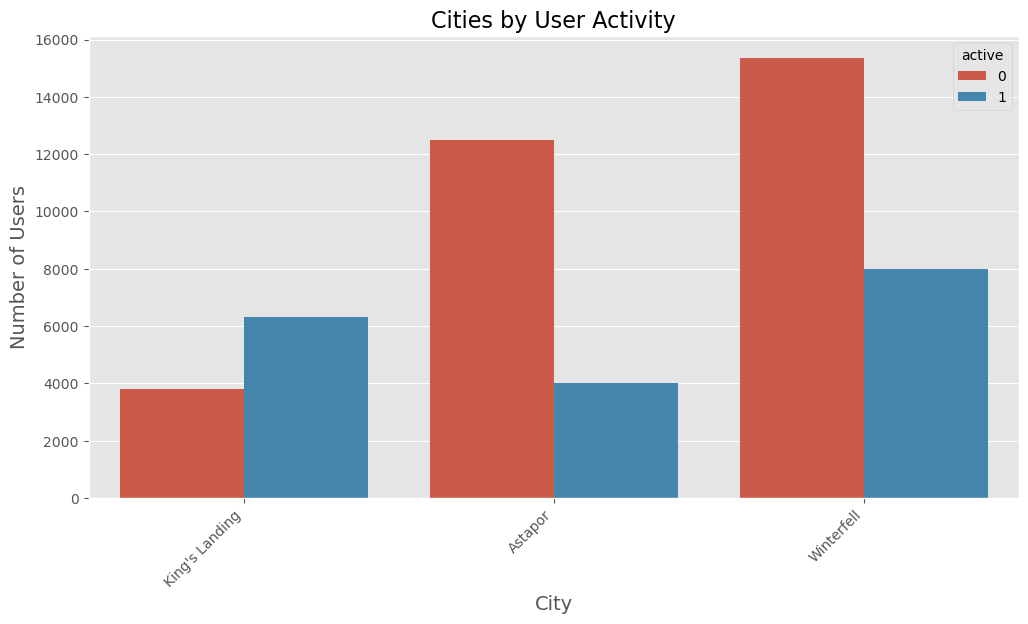

In [23]:
# Plot users by city
cities_count = plt.figure(figsize=(12, 6))
cities_count = sns.countplot(x='city', data=user_df, hue='active')
cities_count = plt.xticks(rotation=45, ha='right')
cities_count = plt.title('Cities by User Activity', fontsize=16)
cities_count = plt.xlabel('City', fontsize=14)
cities_count = plt.ylabel('Number of Users', fontsize=14)

## Winterfell has the most total users, most active users, and most inactive users. Astapor has the lowest percentage of active users while King's Landing has the highest percentage of active users. King's Landing is also the only city that has more active users than inactive users.

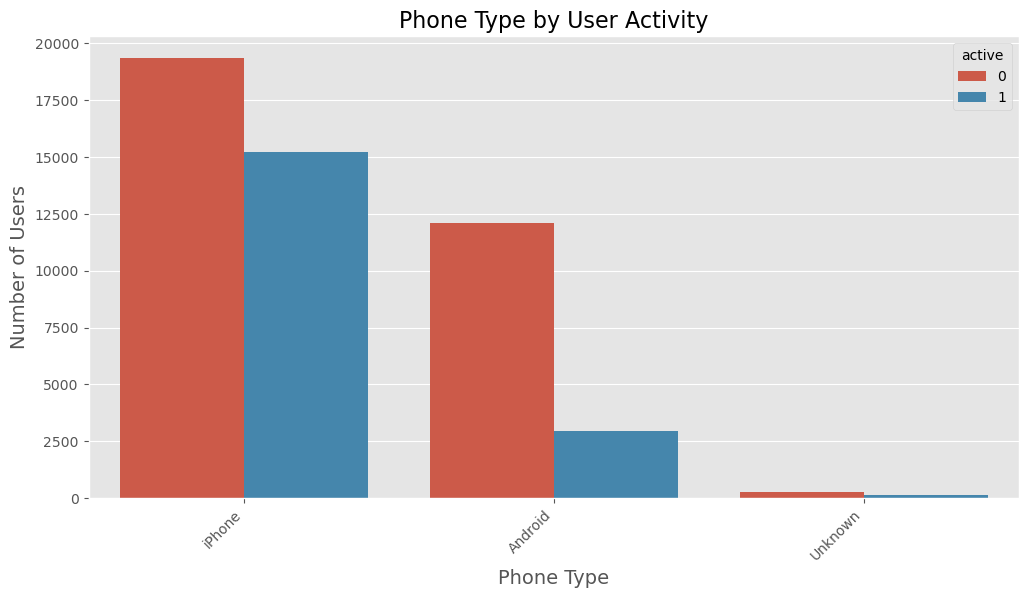

In [24]:
# Plot users by phone
phone_count = plt.figure(figsize=(12, 6))
phone_count = sns.countplot(x='phone', data=user_df, hue='active')
phone_count = plt.xticks(rotation=45, ha='right')
phone_count = plt.title('Phone Type by User Activity', fontsize=16)
phone_count = plt.xlabel('Phone Type', fontsize=14)
phone_count = plt.ylabel('Number of Users', fontsize=14)

## Active users are much more likely to be iPhone users than Android users. Some users phone type is unknown and they are more likely to be inactive users as well

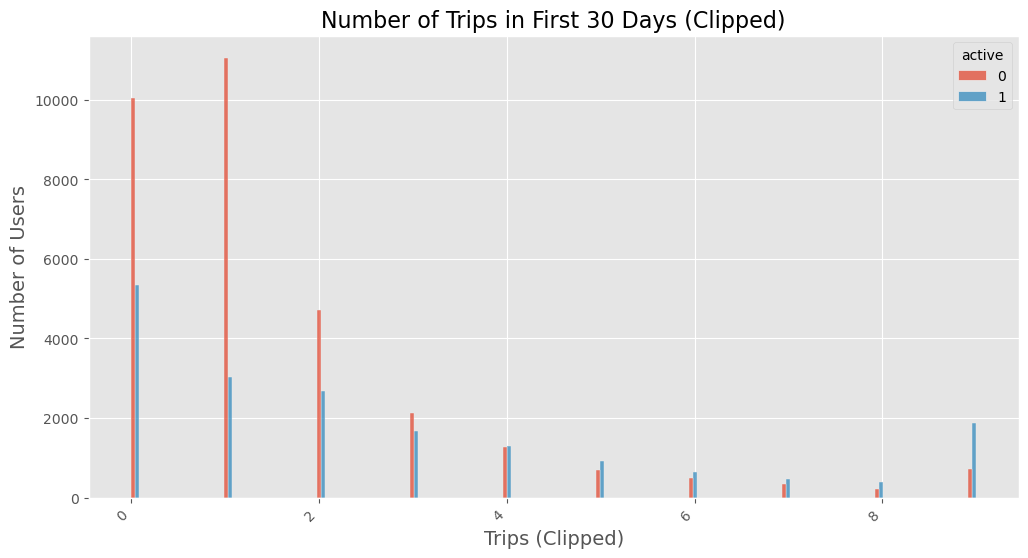

In [25]:
# Plot number of trips in first 30 days with clipped data and hue side by side
upper_limit = user_df['trips_in_first_30_days'].quantile(0.95)

cities_count = plt.figure(figsize=(12, 6))
cities_count = sns.histplot(x=user_df['trips_in_first_30_days'].clip(upper=upper_limit), bins=100, data=user_df, hue='active', multiple='dodge')
cities_count = plt.xticks(rotation=45, ha='right')
cities_count = plt.title('Number of Trips in First 30 Days (Clipped)', fontsize=16)
cities_count = plt.xlabel('Trips (Clipped)', fontsize=14)
cities_count = plt.ylabel('Number of Users', fontsize=14)

## A large number of users, both active and inactive, took 0 trips in the first 30 days which is surprising. When users took 2 or more trips in the first 30 days, their probability of being an active user increases with the more trips taken.

In [26]:
# Create dummy variables for 'city' and 'phone' and add them to the original dataframe
user_df = pd.get_dummies(user_df, columns=['city', 'phone'], drop_first=True)

In [27]:
# Get the maximum 'last_trip_date'
max_last_trip_date = user_df['last_trip_date'].max()

# Calculate the age of the account in days based on the max 'last_trip_date'
user_df['age_of_account_in_days'] = (max_last_trip_date - user_df['signup_date']).dt.days
user_df = user_df.drop(columns=['signup_date'])

# Drop last trip data to prevent data leakage
user_df = user_df.drop(columns=['last_trip_date'])

user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  int64  
 1   avg_rating_of_driver    50000 non-null  float64
 2   avg_surge               50000 non-null  float64
 3   surge_pct               50000 non-null  float64
 4   ultimate_black_user     50000 non-null  bool   
 5   weekday_pct             50000 non-null  float64
 6   avg_dist                50000 non-null  float64
 7   avg_rating_by_driver    50000 non-null  float64
 8   active                  50000 non-null  int64  
 9   city_King's Landing     50000 non-null  bool   
 10  city_Winterfell         50000 non-null  bool   
 11  phone_Unknown           50000 non-null  bool   
 12  phone_iPhone            50000 non-null  bool   
 13  age_of_account_in_days  50000 non-null  int64  
dtypes: bool(5), float64(6), int64(3)
memor

In [28]:
# Split data into Features and target variable 'active'
y = user_df['active']
X = user_df.drop('active', axis=1)

In [29]:
#Split data into Train & Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=7, stratify=y)

In [30]:
#Defining the modeling function

def modeling(alg, alg_name, params={}):
    """
    Fits and trains a given model and computes accuracy scores including accuracy,
        precision, recall, f1 score, full classification report, Matthews correlation coefficient,
        & confusion matrix.

    Parameters:
    - alg: the model function we will be testing.
    - alg_name: name of the model we will be testing.
    - params: parameters if any.

    Returns:
    - model.

    Prints:
    - classification report.
    - scoring metrics.
    - confusion matrix.
    
    """
    global y_pred
    model = alg(**params) #Instantiating the algorithm class and unpacking parameters if any
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #Performance evaluation
    def print_scores(alg, y_test, y_pred):
        print(alg_name)
        acc_score = accuracy_score(y_test, y_pred)
        print("accuracy: ",acc_score)
        pre_score = precision_score(y_test, y_pred)
        print("precision: ",pre_score)
        rec_score = recall_score(y_test, y_pred)
        print("recall: ",rec_score)
        f_score = f1_score(y_test, y_pred, average='weighted')
        print("f1_score: ",f_score)

    report = classification_report(y_test, y_pred)
    print(report)
    
    print_scores(alg, y_test, y_pred)

    # Assuming y_test and y_pred are your true labels and predicted labels respectively
    mcc = matthews_corrcoef(y_test, y_pred)
    print("Matthews correlation coefficient:", mcc)

    # Calculate & plot the confusion matrix as a heatmap
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 16})
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    return model

In [31]:
# Define a function to perform cross-validation

def cross_validate_model(model, X, y, cv=10):
    """
    Perform cross-validation on our model

    Parameters:
    - model: the fit model to perform cross validation on.
    - X: features.
    - y: target.

    Returns:
    - cross validation scores.
    """
    # Perform cross-validation
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

    # Print cross-validation scores
    print("Cross-validation scores:", cv_scores)
    print("Mean CV accuracy:", cv_scores.mean())
    print("Standard deviation of CV accuracy:", cv_scores.std())

In [32]:
#Define a function to plot the ROC Curve and AUC

def plot_roc_auc(model, y_test, title='Receiver Operating Characteristic (ROC) Curve'):
    """
    Plots the ROC curve and calculates the AUC score.

    Parameters:
    - y_test: array-like, shape (n_samples,)
        True binary labels in range {0, 1} or {-1, 1}.
    - y_proba: array-like, shape (n_samples,)
        Target scores, can either be probability estimates of the positive class,
        confidence values, or binary decisions.
    - title: string, optional (default='Receiver Operating Characteristic (ROC) Curve')
        Title of the plot.

    Returns:
    - auc_score: float
        Computed Area Under the Curve (AUC) score.
    """
    #global y_proba
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    if y_proba is not None:
        auc_score = roc_auc_score(y_test, y_proba)
        print(f"AUC Score: {auc_score:.4f}\n")
    else:
        print("\n")
        
    # Calculate ROC curve values
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)

    # Plot ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

    # Calculate AUC score
    auc_score = roc_auc_score(y_test, y_proba)
    print(f'AUC Score: {auc_score:.4f}')
    
    return auc_score

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      9507
           1       0.73      0.65      0.69      5493

    accuracy                           0.78     15000
   macro avg       0.77      0.75      0.76     15000
weighted avg       0.78      0.78      0.78     15000

Random Forest Classifier
accuracy:  0.7820666666666667
precision:  0.726661231145536
recall:  0.6490078281449118
f1_score:  0.7791790190863158
Matthews correlation coefficient: 0.5216213947095837


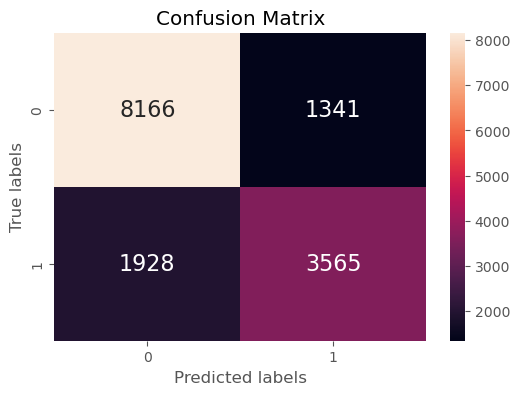

In [33]:
# Random Forest Model
rf_model = modeling(RandomForestClassifier, 'Random Forest Classifier', params={'random_state':7})

In [34]:
# Call the cross-validation function on the Random Forest Model
cross_validate_model(rf_model, X_train, y_train)

Cross-validation scores: [0.76885714 0.786      0.77114286 0.76971429 0.77542857 0.77314286
 0.77657143 0.77942857 0.78171429 0.77742857]
Mean CV accuracy: 0.7759428571428572
Standard deviation of CV accuracy: 0.005189943179272939


AUC Score: 0.8417



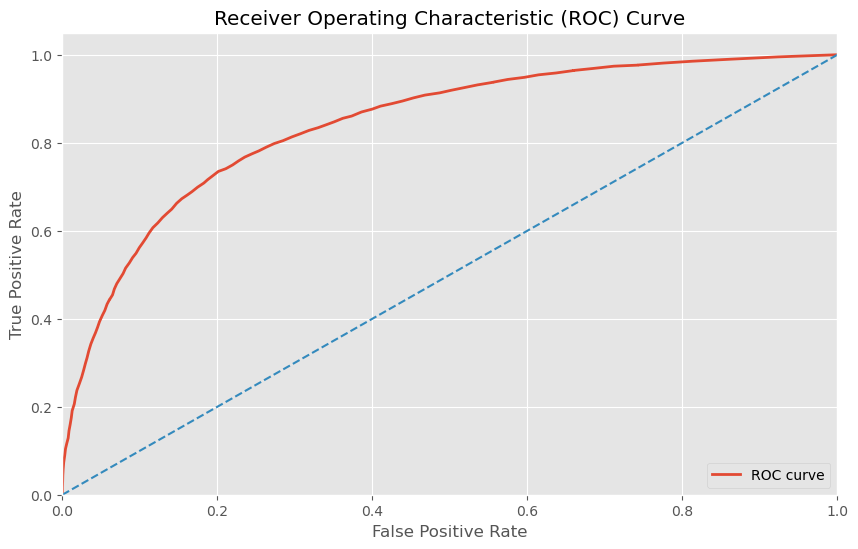

AUC Score: 0.8417


In [35]:
#Call our plot_roc_auc function for the Random Forest Model
plot_roc_auc(rf_model, y_test);

## A cross-validated 77.59% accuracy is not a bad starting point. We'll try a more complex model then tune them boith to see if we can improve upon this.

              precision    recall  f1-score   support

           0       0.82      0.87      0.84      9507
           1       0.75      0.67      0.70      5493

    accuracy                           0.80     15000
   macro avg       0.78      0.77      0.77     15000
weighted avg       0.79      0.80      0.79     15000

XGBoost
accuracy:  0.7958666666666666
precision:  0.7491289198606271
recall:  0.6653923174949936
f1_score:  0.7930173737966594
Matthews correlation coefficient: 0.5518697328278167


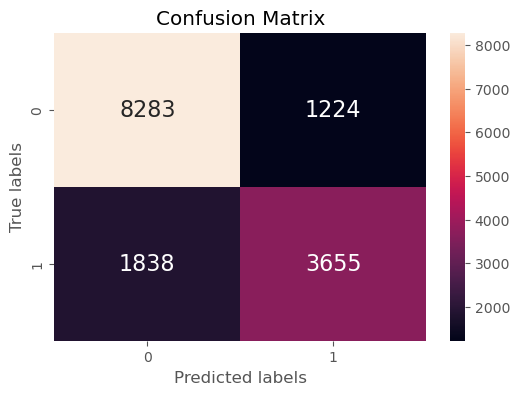

In [36]:
# XGBoost
xgb_model = modeling(XGBClassifier, 'XGBoost', params={'random_state':7})

In [37]:
# Call the cross-validation function on the XGBoost Model
cross_validate_model(xgb_model, X_train, y_train)

Cross-validation scores: [0.78028571 0.794      0.78485714 0.78171429 0.78428571 0.78428571
 0.78657143 0.78971429 0.794      0.78714286]
Mean CV accuracy: 0.7866857142857142
Standard deviation of CV accuracy: 0.004437686472080923


AUC Score: 0.8417



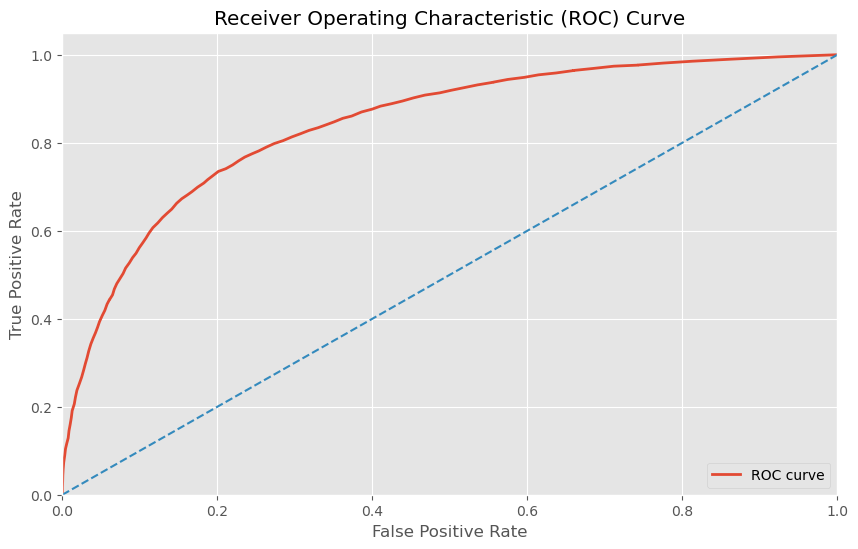

AUC Score: 0.8417


In [38]:
#Call our plot_roc_auc function for the XGBoost Model
plot_roc_auc(rf_model, y_test);

## Our mean cross validated accuracy increased slightly to 78.66%. We'll move on to tuning both models to ensure the best fit.

Time taken for GridSearchCV: 443.45 seconds
Best Parameters: {'criterion': 'entropy', 'n_estimators': 500}
Best Cross-Validation Score: 0.7764
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      9507
           1       0.73      0.66      0.69      5493

    accuracy                           0.78     15000
   macro avg       0.77      0.76      0.76     15000
weighted avg       0.78      0.78      0.78     15000



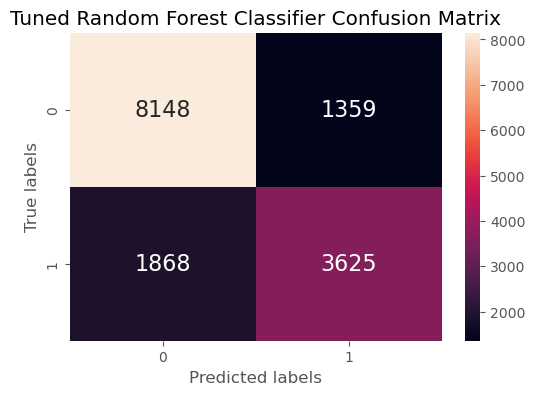

In [39]:
# Random Forest Classifier Hyperparameter tuning

# Define the model
rf = RandomForestClassifier(random_state=7)

# Define the parameter grid
param_grid = {'n_estimators': [10, 50, 100, 200, 300, 400, 500],
              'criterion': ["gini", "entropy", "log_loss"]}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')

# Measure the time taken to run GridSearchCV
start_time = time.time()

# Run GridSearchCV on the training data
grid_search.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time

# Print the elapsed time
print(f'Time taken for GridSearchCV: {elapsed_time:.2f} seconds')

# Print the best parameters and the best score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Cross-Validation Score: {grid_search.best_score_:.4f}')

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Calculate & plot the confusion matrix as a heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 16})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Tuned Random Forest Classifier Confusion Matrix')
plt.show()

In [40]:
# Feature Importance
fi = pd.Series(best_model.feature_importances_, index=X.columns)
fi = fi.sort_values(ascending=False)
fi

avg_dist                  0.220804
age_of_account_in_days    0.147928
weekday_pct               0.116072
avg_rating_by_driver      0.098213
trips_in_first_30_days    0.077320
avg_rating_of_driver      0.076931
surge_pct                 0.067589
avg_surge                 0.056431
city_King's Landing       0.055371
phone_iPhone              0.035489
ultimate_black_user       0.029739
city_Winterfell           0.016107
phone_Unknown             0.002006
dtype: float64

## After tuning, our Random Forest Classifier's accuracy slightly increased to a mean cross validated accuracy of 77.64%. The most important features in predicting were average distance and age of account in days.

Time taken for GridSearchCV: 246.78 seconds
Best Parameters: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 400}
Best Cross-Validation Score: 0.7943
              precision    recall  f1-score   support

           0       0.82      0.87      0.85      9507
           1       0.75      0.67      0.71      5493

    accuracy                           0.80     15000
   macro avg       0.79      0.77      0.78     15000
weighted avg       0.79      0.80      0.79     15000



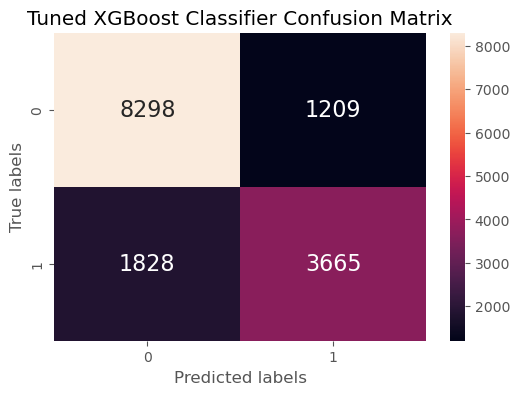

In [41]:
# XGBoost Classifier Hyperparameter tuning

# Define the model
xgb_model = XGBClassifier(random_state=7)

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'gamma': [0, 0.1, 0.2]}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')

# Measure the time taken to run GridSearchCV
start_time = time.time()

# Run GridSearchCV on the training data
grid_search.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time

# Print the elapsed time
print(f'Time taken for GridSearchCV: {elapsed_time:.2f} seconds')

# Print the best parameters and the best score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Cross-Validation Score: {grid_search.best_score_:.4f}')

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Calculate & plot the confusion matrix as a heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 16})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Tuned XGBoost Classifier Confusion Matrix')
plt.show()

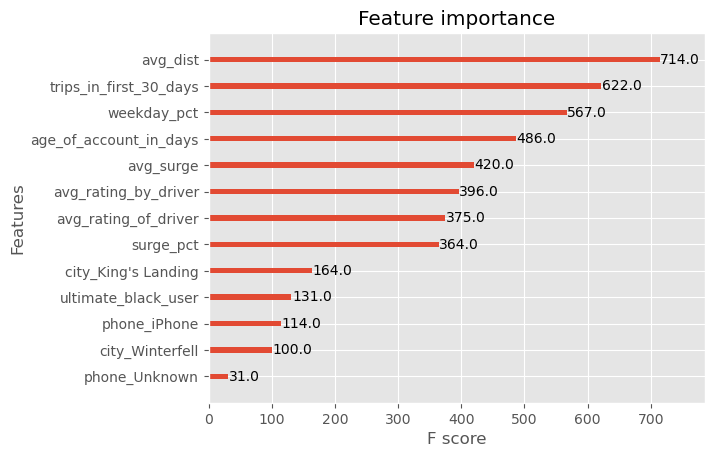

In [42]:
# Feature Importance
xgb_fi = plot_importance(best_model)

## Our XGBoost model's mean cross-validated accuracy increased to 79.43%. This model was also faster to run than the random forest classifier so we would want to put this model into production. The most important features for the XGBoost classifier were average trip distance and number of trips in the first 30 days.

# Conclusion
The most important features to accurately predict user retention are average trip distance and number of trips in the first 30 days. Ultimate would be wise to market to users who typically take long haul trips and offer incentives to users in their first 30 days to promote more trips in general. Long haul users that Ultimate could target in marketing are commuters between two major cities such as those that commute regularly between San Diego & LA. Ultimate could incentivize users to take more trips in their first 30 days by offering a reward system where users get a ride free after a certain number of paid rides, 2 for 1's, or half off rides during the slowest periods of the day.